# 2. Data Preparation

본 챕터에서는 모빌리티 시뮬레이션을 구축하는데 필요한 기본적인 입력데이터들을 살펴본다. 단순히 데이터를 살펴보는데서 끝나지 않고 간단한 데이터의 전처리 및 시각화의 실습과정도 포함하고 있다.

매우 다양한 형태의 모빌리티 데이터가 존재하며, 이들을 분류하는 기준 역시 분석자의 목표에 따라 여려가지로 구분할 수 있지만 본 책에서는 크게 아래와 같은 형태의 데이터를 살펴볼 것이다.
1. 통행수요 데이터 (Travel Demand)
    - 시뮬레이션을 하기 위한 승객의 수요를 생성하는 기초자료로 활용됨
2. 통행시간 데이터 (Travel Time)
    - 시뮬레이션을 Calibration 하는데 활용
    - e.g., 출퇴근 시간의 교통 정체, 새벽시간대의 빠른 속도를 시뮬레이션에 반영 가능함
3. 도로 네트워크 데이터 (Road Network)
    - 도로 위를 움직이는 차량 구현 (Vehicle Router)
4. 대중교통 네트워크 데이터 (Public Transit Network)
    - 버스, 지하철과 같은 노선과 배차간격이 정해진 모빌리티 시스템을 구현하는데 사용

## 2.1 Travel Demand Data (Trip record data)

### 2.1.1 활용 데이터
- 통행수요는 특정지역에서 출발(Trip Production)하거나, 특정지역으로 도착하는 통행(Trip Attraction) 형태로 존재할 수도 있고, 혹은 더 세분화 한다면 출발지-목적지 단위의 통행수요(Origin-Destination (OD) Travel Demand)로 나타낼 수 있다. 
- 최근 많은 사람들이 스마트폰을 사용하고 따라서 통신사 기지국 기반으로 세밀한 통행패턴이 수집 가능하며, O-D 단위의 통행수요 데이터를 구득하기가 수월해졌다. 따라서 본 교재에서는 O-D 단위의 통행 데이터를 주로 활용하는 실습을 진행할 예정이다. 
- 본 예제에서는 서울시에서 제공하는 수도권 생활이동 데이터를 활용하였다. 
    - https://data.seoul.go.kr/dataVisual/seoul/capitalRegionLivingMigration.do
- 컬럼의 명세는 아래와 같다. 행정동 단위의 O-D 통행량 및 통행시간 정보를 제공해주고 있다. 더 상세하게는 내/외국인 구분, 국적, 이동목적과 같은 정보도 제공을 해준다.


| 순번 | 영문 컬럼명 | 컬럼 설명 | NULL 여부 | NULL 대체값 | 형식 | 규칙 | 데이터 허용범위 | 비고 |
|------|------------|-----------|-----------|-------------|------|------|-----------------|------|
| 1 | O_ADMDONG_CD | 출발 행정동 | X | - | STRING | - | - | 행안부 8자리 코드체계 |
| 2 | D_ADMDONG_CD | 도착 행정동 | X | - | STRING | - | - | 행안부 8자리 코드체계 |
| 3 | ST_TIME_CD | 출발 시간 | X | - | STRING | - | - | 7~9시/17시~19시는 20분단위, 그 외 1시간 단위 |
| 4 | FNS_TIME_CD | 도착 시간 | X | - | STRING | - | - | 7~9시/17시~19시는 20분단위, 그 외 1시간 단위 |
| 5 | IN_FORN_DIV_NM | 내/외국인 구분 | X | - | STRING | - | - | 내국인, 단기외국인, 장기외국인 |
| 6 | FORN_CITIZ_NM | 국적 | X | - | STRING | - | - | 　 |
| 7 | MOVE_PURPOSE | 이동 목적 | X | - | STRING | - | - | 1: 출근, 2 : 등교, 3: 귀가, 4: 쇼핑, 5: 관광, 6: 병원, 7: 기타 |
| 8 | MOVE_DIST | 평균 이동 거리(m) | X | - | DOUBLE | - | - | 　 |
| 9 | MOVE_TIME | 평균 이동 시간(분) | X | - | DOUBLE | - | - | 　 |
| 10 | CNT | 이동인구 수 | X | - | DOUBLE | (18,2) | - | 　 |
| 11 | ETL_YMD | 기준 년월 일 | X | - | STRING | yyyyMMdd | 데이터 기준 당일 | - |

데이터셋 명: 출도착 행정동별 이동 목적 데이터  ·
DB 명: PURPOSE_ADMDONG3

### 2.1.2 데이터 읽기 및 간단한 전처리

- 간단한 예제를 위해 서울시에서 제공하는 [수도권 생활이동](https://data.seoul.go.kr/dataVisual/seoul/capitalRegionLivingMigration.do) 데이터 중, 2024년 3월 27일 하루치의 데이터만을 예제로 사용하였다. 
- 원활한 실습을 위해 모든 데이터는 Google Drive에 업로드 하였으며, `gdown` 패키지를 사용해 데이터를 다운로드 받은 후 로드하는 방식을 사용하였다. 

In [8]:
import gdown
import pandas as pd
import os

In [13]:
def download_and_read_parquet(file_id, output_path="../data/chp2_od_data.parquet"):
    try:
        # Google Drive에서 파일 다운로드
        gdown.download(id=file_id, output=output_path, quiet=False)
        
        # Parquet 파일을 DataFrame으로 읽기
        df = pd.read_parquet(output_path)
        
        # 임시 파일 삭제 (데이터 용량이 매우 큰 경우 사용)
        # os.remove(output_path) # 다운로드 받은 데이터를 삭제하고 싶지 않을 때는 해당 라인을 주석처리
        
        return df
    except Exception as e:
        print(f"오류 발생: {e}")
        return None

In [14]:
# 파일 불러오기
file_id = "1teftc2KgWrG0Jn2SyyY3pipkBugmvnex" # 구글 드라이브에 업로드 된 파일의 ID
df = download_and_read_parquet(file_id)

Downloading...
From: https://drive.google.com/uc?id=1teftc2KgWrG0Jn2SyyY3pipkBugmvnex
To: f:\mobility-simulation-book\data\chp2_od_data.parquet
100%|██████████| 56.6M/56.6M [00:01<00:00, 35.2MB/s]


인터넷 환경으로 인해 파일을 불러오는게 느리다면, github에서 clone 할 때 가지고 온 data 폴더에 있는 파일을 직접 열 수 있다.  
아래 코드를 실행해 보자.  
```code-cell
df = pd.read_parquet("../data/chp2_od_data.parquet")
```

In [17]:
df

,O_ADMDONG_CD,D_ADMDONG_CD,ST_TIME_CD,CNT,MOVE_DIST,MOVE_TIME
0,11110515,11110515,0,25.54,151.875714,1683.637143
1,11110515,11110515,1,79.29,104.120000,1210.596667
2,11110515,11110515,2,103.07,175.205714,360.190000
3,11110515,11110515,3,16.30,239.946667,2441.596667
4,11110515,11110515,4,34.73,215.720000,860.990000
...,...,...,...,...,...,...
3792913,52800410,41590360,11,2.56,69512.350000,4087.830000
3792914,52800420,11350570,14,3.50,66976.630000,6354.770000
3792915,52800420,11440630,9,3.48,63894.260000,3725.740000
3792916,52800420,41273610,17,2.33,69839.840000,1864.100000


## 2.2 Travel Time Data

## 2.3 Road Network and Geometry

### 2.3.1 Open Street Map

[오픈스트리트맵 한국](https://osm.kr/usage/)에서는 대한민국의 OSM을 이용하는 상세한 방법에 대한 메뉴얼을 제공해주고 있다. 상세한 내용은 이곳을 참고하면 되며, 본 장에서는 한국의 OSM 데이터를 불러와서 `OSMnx` 패키지로 간략히 분석하고 시각화 하는 작업을 진행한다. 

- OSM을 이용해서 수도권 지역의 도로 데이터를 가져오고, 시각화 하는 작업을 수행한다  
- OSMnx 이용해서 그래프 분석하고, 복잡한 그래프를 간소화 하는 작업을 실습한다

#### [1] .osm.pbf 파일 다운로드
- 사이트 : https://download.geofabrik.de/asia.html
- South Korea 부분의 .osm.pbf 버튼 클릭

In [19]:
import networkx as nx
import osmnx as ox

ox.config(use_cache=True, log_console=True)
ox.__version__

C:\Users\rnt53\AppData\Local\Temp\ipykernel_13568\606638948.py:4: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


'1.9.4'

#### [2] 내가 원하는 지역 osm 지도를 그래프 형태로 표현

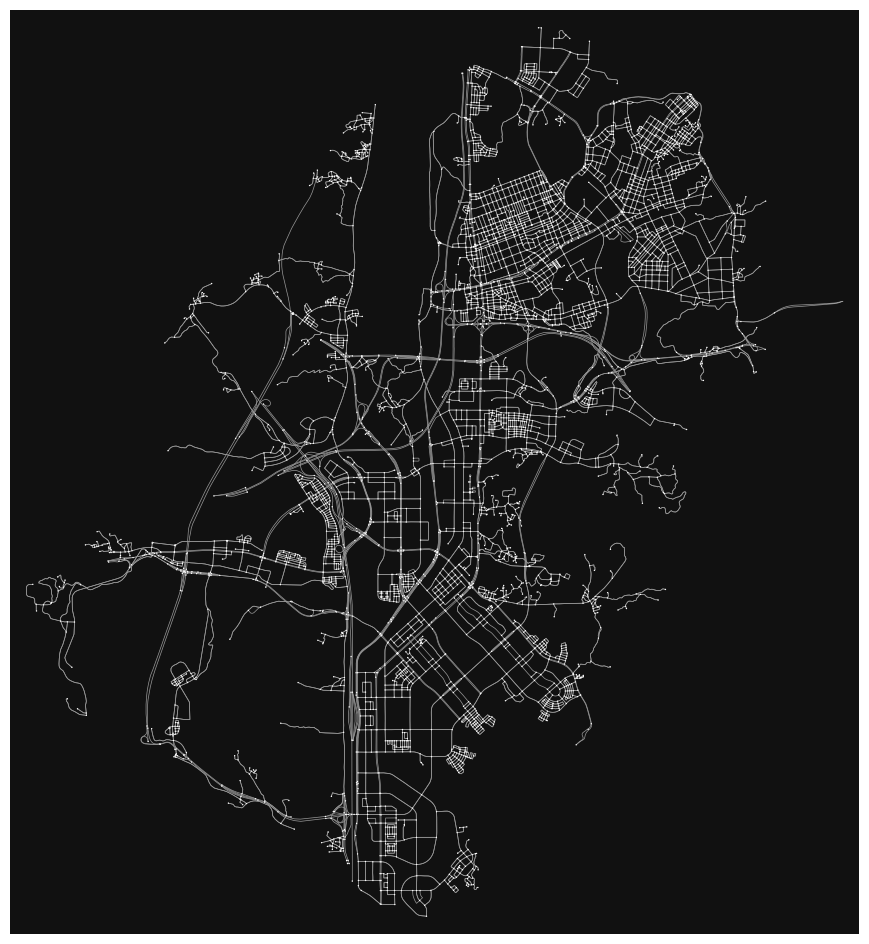

In [ ]:
# get a graph for some city
# www.openstreetmap.org에서 검색 결과가 city-state-country 단위로 나와야 함 

# # 서울특별시 전체 도로 네트워크 불러오기
# G = ox.graph_from_place('서울특별시, 대한민국', network_type='drive')

# osmnx 그래프 생성( osm 지도 다운로드 )
G = ox.graph_from_place('성남시, 경기도, 대한민국', network_type='drive')

## 시각화
# fig, ax = ox.plot_graph(G)
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(12, 12),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

#### [3] 원하는 지역의 폴리곤을 활용하여 주변 반경 네트워크 시각화

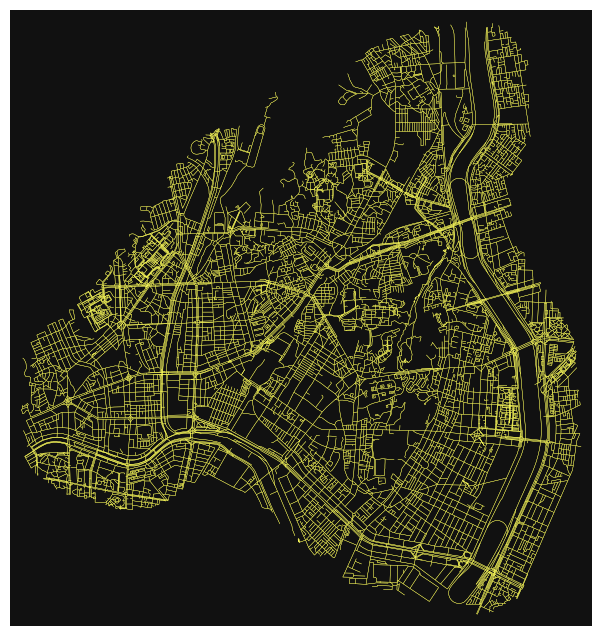

In [ ]:
# Piedmont, California 지역의 폴리곤(경계) 정보를 GeoDataFrame으로 가져옴
# polygon = ox.geocode_to_gdf("Piedmont, California, USA").loc[0, "geometry"]
polygon = ox.geocode_to_gdf('동대문구, 서울, 대한민국').loc[0, "geometry"]


# 가져온 폴리곤을 적절한 투영 좌표계로 변환 (투영 좌표계를 사용하면 거리 계산이 정확해짐)
poly_proj, crs_proj = ox.projection.project_geometry(polygon)

# 투영된 폴리곤에 500미터의 버퍼를 추가하여, 해당 지역으로부터 500미터 내외의 범위 생성
# 투영 좌표계를 다시 위도/경도로 변환 (WGS84)
polygon, _ = ox.projection.project_geometry(poly_proj.buffer(500), crs=crs_proj, to_latlong=True)

# 생성된 500미터 버퍼 내에서 도보 네트워크를 가져옴
G = ox.graph_from_polygon(polygon, network_type="walk")

# 시각화
fig, ax = ox.plot_graph(
    G,                      #
    node_size=0,            # 노드 크기를 0으로 설정 (노드 표시 안함)
    edge_color="#FFFF5C",    # 엣지 색상을 노란색으로 설정
    edge_linewidth=0.25      # 엣지의 두께를 0.25로 설정
)


#### [4] 여러 네트워크를 한번에 표시

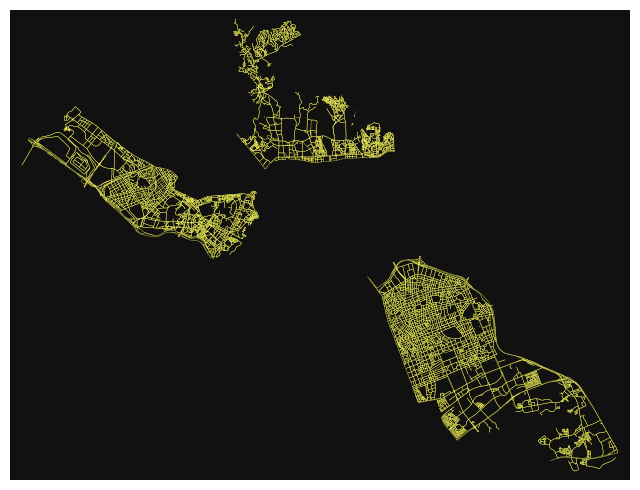

In [ ]:
# 여러 위치에서 네트워크를 생성하기 위한 서울 지역 리스트 설정
places = [
    "Jongno-gu, Seoul, South Korea",  
    {"city": "Gangnam-gu", "state": "Seoul"},  
    "Mapo-gu, Seoul, South Korea",  
]

# retain_all=True를 사용하여 모든 연결되지 않은 서브그래프도 유지 (연속된 네트워크가 아닌 경우에도 유지)
# 여러 장소를 기반으로 차량 도로 네트워크(network_type="drive")를 생성
G = ox.graph_from_place(places, network_type="drive", retain_all=True)

# 생성된 네트워크 시각화 
fig, ax = ox.plot_graph(
    G,                      
    node_size=0,           
    edge_color="#FFFF5C",    
    edge_linewidth=0.25      
)

#### [5]  도로망 중심성 시각화

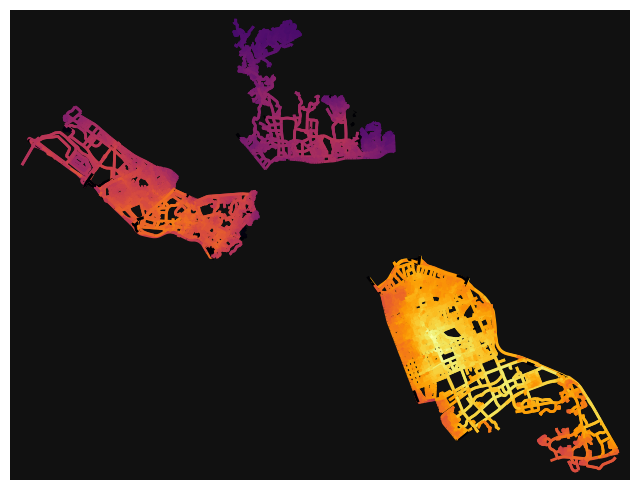

In [ ]:
# 그래프의 간선을 노드로, 노드를 간선으로 변환하여 line graph 생성
# (간선 중심성을 계산하기 위해 Line Graph 기법을 사용)
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

# 원래 그래프 G의 각 간선에 대해 closeness centrality 값을 속성으로 설정
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

# 원래 그래프의 간선을 중심성 값으로 색칠하기 위해 컬러맵(inferno)을 사용하여 색상 설정
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')

# closeness centrality 값을 바탕으로 색상이 지정된 간선을 가진 그래프 시각화
fig, ax = ox.plot_graph(
                        G,                  # 시각화할 그래프
                        edge_color=ec,      # 간선의 색상 (중심성 값에 따라 설정된 색상)
                        edge_linewidth=2,   # 간선의 두께
                        node_size=0         # 노드 크기 (0으로 설정하여 노드 미표시)
                        )

#### [6] 최단거리 분석

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline

In [ ]:
# pip install scikit-learn
# pip install folium
# pip install scipy

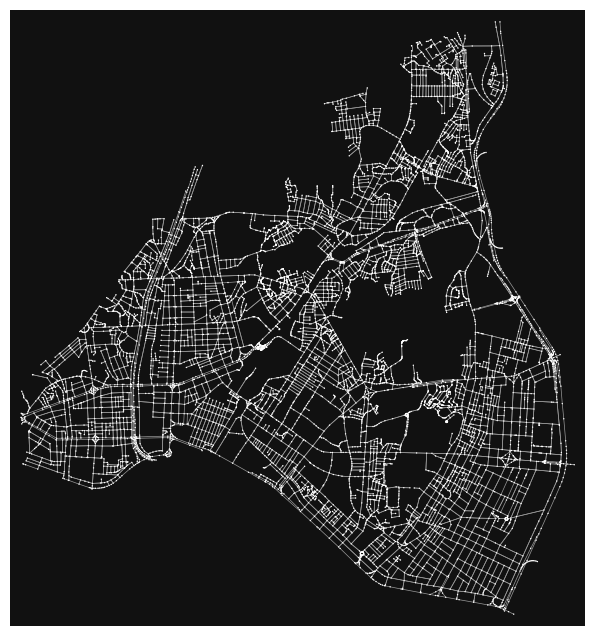

In [ ]:
# 원하는 지역 그래프 생성
G = ox.graph_from_place('동대문구, 서울, 대한민국', network_type='drive', simplify=False)

# 그래프 시각화
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(8, 8),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

In [ ]:
## 직각 좌표계로 변환
# G_proj = ox.project_graph(G)

# 출발지 도착지 좌표 설정( 좌표와 가장 가까운 노드를 찾아줌 )
orig_node = ox.nearest_nodes(G, 127.0462200, 37.5804100) #청량리역
dest_node = ox.nearest_nodes(G, 127.0114887, 37.5718616) #동대문역

In [ ]:
# 최단 거리 경로 추출
route = nx.shortest_path(G, orig_node, dest_node, weight='length')

In [ ]:
# 최단 거리 추출
len = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / 1000
print(round(len, 1), "킬로미터")

2.9 킬로미터


In [ ]:
# 촤단거리 지도 생성
route_graph_map = ox.plot_route_folium(G, route, popup_attribute='length')
    
# 출발지와 목적지 좌표
orig_node_xy = (G.nodes[orig_node]['y'], G.nodes[orig_node]['x'])  # (위도, 경도)
dest_node_xy = (G.nodes[dest_node]['y'], G.nodes[dest_node]['x'])  # (위도, 경도)

# 출발지 마커 추가
folium.Marker(location=orig_node_xy, popup='출발지', icon=folium.Icon(color='green')).add_to(route_graph_map)

# 목적지 마커 추가
folium.Marker(location=dest_node_xy, popup='목적지', icon=folium.Icon(color='red')).add_to(route_graph_map)

# 지도 시각화
route_graph_map

# 지도 저장 
# filepath = 'data/route_graph.html' # 경로 지정
# route_graph_map.save(filepath)

C:\Users\alstn\AppData\Local\Temp\ipykernel_7400\861946550.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_graph_map = ox.plot_route_folium(G, route, popup_attribute='length')


#### [7] 이동 속도 및 시간 영향

In [ ]:
# 위의 그래프의 모든 엣지에 속도를 부여
G = ox.add_edge_speeds(G)

# 모든 에지에 대한 이동 시간(초) 계산
G = ox.add_edge_travel_times(G)

In [ ]:
# 도로 유형별 평균 속도/시간 값 보기
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
living_street,22.2,44.6,1.8
primary,31.5,56.2,2.0
primary_link,12.7,30.0,1.5
residential,27.5,30.4,3.3
secondary,31.7,42.5,2.7
secondary_link,16.5,46.2,1.3
tertiary,34.6,30.7,4.1
tertiary_link,20.9,44.6,1.7
trunk,54.0,76.1,2.5


In [ ]:
# 도로 별 속도 지정
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60} # residential : 주거지도로 secondary : 지방도 tertiary: 시도·군도·구도
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)

In [ ]:
# 이동 거리와 이동 시간을 최소화한 두 가지 경로를 계산합니다

# 그래프 내에서 출발지 목적지 가져오기
orig = list(G)[1]
dest = list(G)[111]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

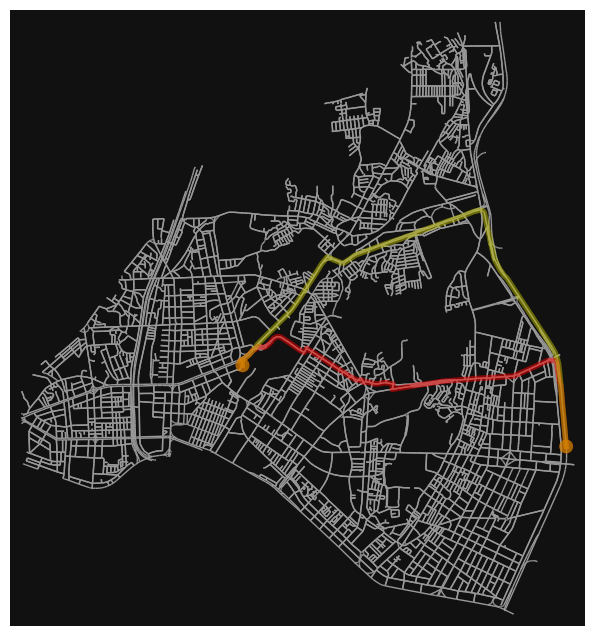

In [ ]:
# 시각화
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [ ]:
# 두 경로 비교

# route1의 길이 계산 (거리 기준 최적 경로의 총 길이, 단위: 미터)
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))

# route2의 길이 계산 (시간 기준 최적 경로의 총 길이, 단위: 미터)
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))

# route1의 소요 시간 계산 (거리 기준 최적 경로의 총 소요 시간, 단위: 초)
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))

# route2의 소요 시간 계산 (시간 기준 최적 경로의 총 소요 시간, 단위: 초)
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))

# 두 경로의 길이와 소요 시간을 출력
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")


Route 1 is 3897 meters and takes 325 seconds.
Route 2 is 4942 meters and takes 300 seconds.


#### [8] 특정 노드에서 지정한 거리/시간에 도달할 수 있는 노드 분석( 버퍼 )

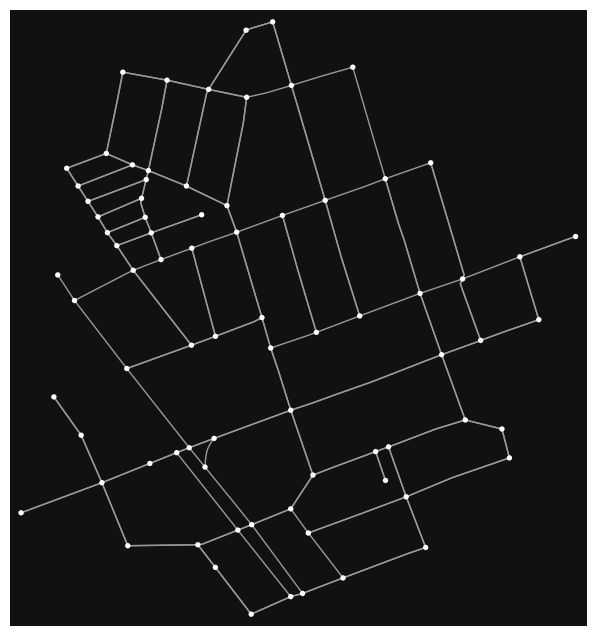

In [ ]:
# 도로 네트워크 불러오기
G = ox.graph_from_place('Gangnam, Seoul, South Korea', network_type='drive')

# 특정 노드를 선택 (예: 첫 번째 노드를 선택)
center_node = list(G.nodes)[0]

# 특정 노드를 중심으로 반경 500m 내의 서브그래프를 ego_graph로 추출
radius = 500  # 반경 (미터 단위)
ego_G = nx.ego_graph(G, center_node, radius=radius, distance='length')

# 서브그래프를 시각화
fig, ax = ox.plot_graph(ego_G)

#### [9] SIMPLIFY

###### 1

c:\Users\alstn\AppData\Local\Programs\Python\Python38\lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


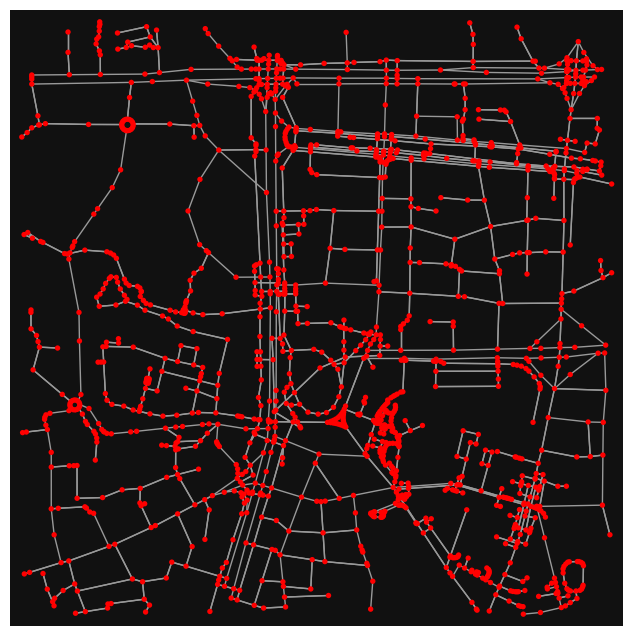

In [ ]:
# 중심 위치 지점(위도, 경도) 정의 ( 서울 시청 )
location_point = (37.5665, 126.9780)

# 중심 위치로부터 500미터 거리 내에서 도로 네트워크 생성
# simplify=False로 설정하여 네트워크를 아직 단순화하지 않음
G = ox.graph_from_point(location_point, dist=500, simplify=False)

# 단순화되지 않은 네트워크 그래프를 플로팅. 노드는 빨간색(r)으로 표시됨
fig, ax = ox.plot_graph(G, node_color="r")

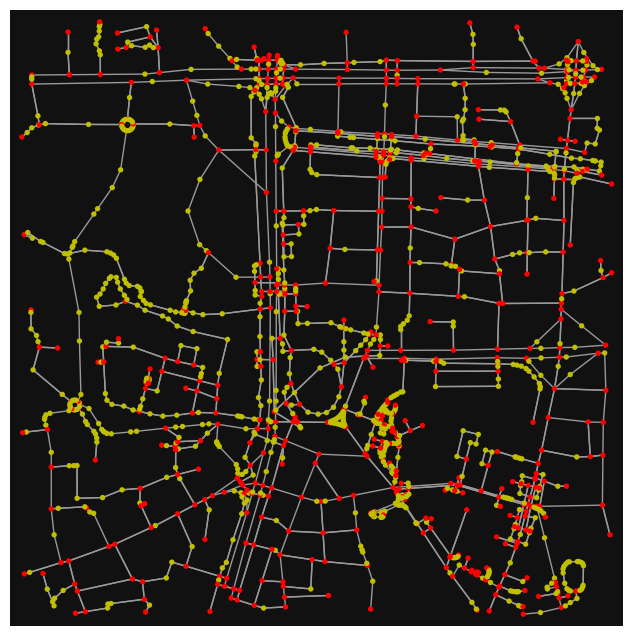

In [ ]:
# 네트워크가 단순화될 때 제거될 노드를 강조
# 끝점인 노드는 빨간색(r)으로 남고, 끝점이 아닌 노드는 노란색(y)으로 표시됨
nc = ["r" if ox.simplification._is_endpoint(G, node, None) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

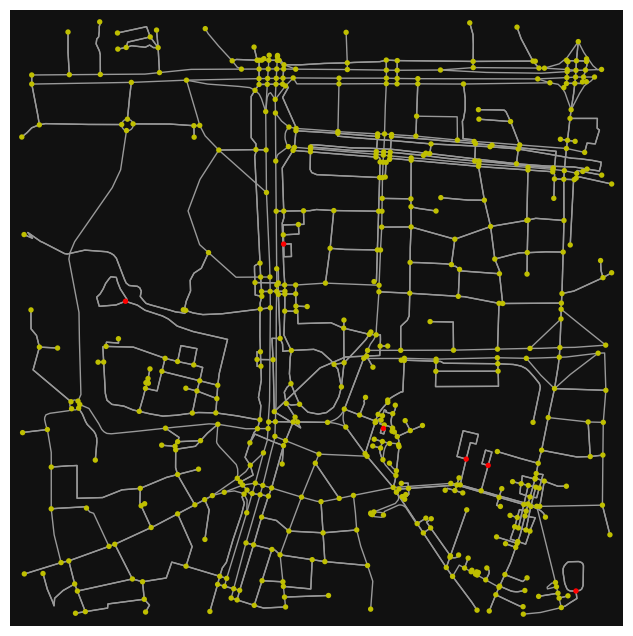

In [ ]:
# 네트워크를 단순화하여 불필요한 중간 노드를 병합
# 위의 노란색 점 제거
G2 = ox.simplify_graph(G)

# 단순화된 그래프에서 자기 루프(self-loop) 엣지와 연결된 노드를 강조
# 자기 루프 엣지는 노드가 자기 자신과 연결되는 엣지임. 이런 노드는 빨간색(r)으로,
# 나머지 노드는 노란색(y)으로 표시됨
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ["r" if node in loops else "y" for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc)

###### 2

- strict 모드는 엣지 속성이 서로 다르면 다른 도로로 간주하고 병합하지 않음
- strict 모드 해제는 일부 엣지 속성의 차이를 무시하고, 엣지가 달라도 연결 가능한 도로로 처리하겠다는 뜻

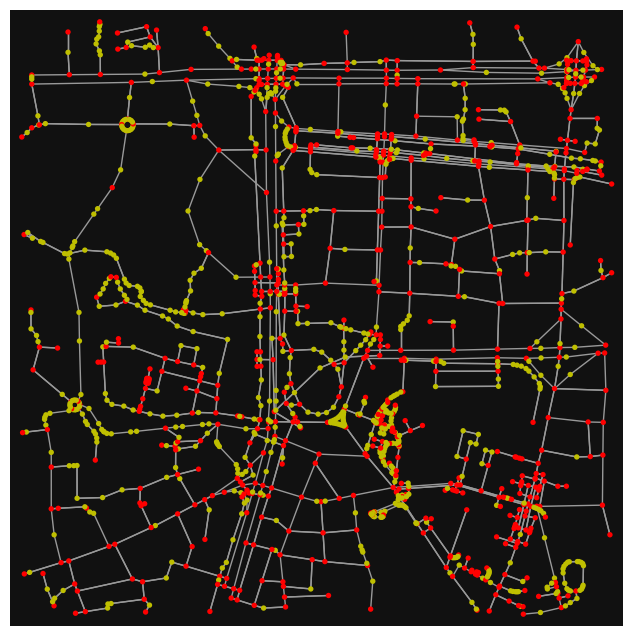

In [ ]:
# 이제 strict 모드를 해제하고, 엣지 속성의 차이를 허용하도록 설정
# 엣지 매칭 조건을 완화했을 때 제거될 노드를 확인

# 각 노드에 대해 끝점 여부를 판단하여, 끝점인 경우 빨간색(r), 끝점이 아닌 경우 노란색(y)으로 표시
nc = [
    "r" if ox.simplification._is_endpoint(G, node, ["osmid"]) else "y" for node in G.nodes() # osmid : OpenStreetMap ID -> 도로 판별 기준점
]

# 시각화화
fig, ax = ox.plot_graph(G, node_color=nc)

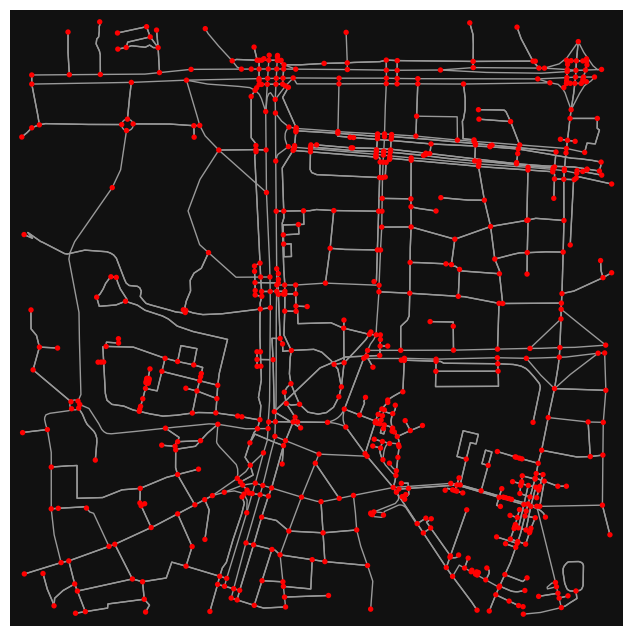

In [ ]:
# strict 모드를 해제한 상태로 다시 네트워크 단순화
# `edge_attrs_differ` 파라미터를 통해 특정 엣지 속성 차이를 무시하며 단순화함 (예: 'osmid')
# 위의 노란색 점 제거
G3 = ox.simplify_graph(G.copy(), edge_attrs_differ=["osmid"])

# strict 모드가 해제된 단순화된 네트워크를 플로팅, 모든 노드는 빨간색(r)으로 표시됨
fig, ax = ox.plot_graph(G3, node_color="r")

## 2.4 GTFS (General Transit Feed Specification)

- 대중교통 네트워크 분석을 위한 데이터
- 향후 업데이트 예정

## 2.5 Exercise

GPT와 같은 AI 툴을 적극 활용해 문제를 풀어봅시다. 다만, 출력된 코드를 보고 이해하고, 코드가 실행되지 않는다면 어디서 실행되지 않는지 파악하고 올바르게 수정할 수 있어야 합니다.

### 2.5.1 통행 수요 데이터 분석 및 시각화

> 2.1 Section에서 불러온 2024년 3월 27일 통행 데이터를 가지고 아래와 같은 분석을 수행해보자.

1. 시간에 따른 통행량을 그래프로 시각화 해보자. 몇시에 통행이 가장 많으며, 그 양은 얼마인가?  
2. 공간에 따른 통행량의 분포를 읍면동 단위로 시각화 해보자. 어느 지역에서 출발 통행량(Trip Production)이 가장 많으며 어느 지역에서 도착 통행량 (Trip Attraction)이 가장 많은가?  
3. 통행의 시공간적 분포를 함께 분석해보자. 가장 효과적인 시각화 방안은 무엇일까?  
4. 출발통행, 도착통행이 아닌, 출발지-목적지간의 통행을 시각화 해보자. O-D pairs의 수가 지나치게 많다면 이를 효과적으로 시각화 할 수 있을까? 어떤 패키지나 소프트웨어를 활용하면 좋을지 고민해보자. 